# libs

In [1]:
import pymc3 as pm
import arviz as az

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import hashlib
import datetime
import warnings
import pickle
import gc

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

In [4]:
from IPython.display import display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [13, 7]

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import normalize, StandardScaler, LabelBinarizer
from sklearn.metrics         import classification_report, roc_curve, auc,accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve
from boruta                  import BorutaPy

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

import lightgbm as lgb         

In [7]:
import theano.tensor as tt

In [8]:
import umap

# dados

In [9]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['sum', 'max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['sum','max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

,Nome,Clube,Preço,J,Média,Últ. Pont.,Variação,DS,G,A,...,GS,FC,I,PI,rodada,ano,RB,PE,id,pos
7882,Ricardo Bueno (ATA),Ceará,18.52,1.0,22.70,22.7,14.52,NaN,2.0,1.0,...,NaN,2.0,1.0,NaN,1,2019,1.0,1.0,1f4d452190fb0558c5f5696b944b9afe4b02ca08,ATA
7883,Bruno Henrique (ATA),Flamengo,21.51,1.0,21.00,21.0,11.51,NaN,2.0,NaN,...,NaN,1.0,NaN,NaN,1,2019,NaN,NaN,9f9a076464350d81d76c9b8940d64b9890e4b053,ATA
7884,Nikão (MEI),Athlético-PR,19.29,1.0,18.80,18.8,10.29,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,1,2019,5.0,NaN,9752a812f300239c0f4fcae95d41e2843653a308,MEI
7885,Tiepo (GOL),Chapecoense,13.18,1.0,17.00,17.0,11.18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2019,NaN,NaN,ec9799d86e28ec368cccfb660bf39ff3bc3eed7c,GOL
7886,Vanderlei (GOL),Santos,22.69,1.0,15.70,15.7,5.69,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,1,2019,NaN,1.0,a5dde5accc0044a9808b0257f6faa5ba89342b7f,GOL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,Jadson (MEI),Athlético-PR,3.53,9.0,0.11,0.8,-0.40,NaN,NaN,NaN,...,NaN,3.0,NaN,40.0,38,2020,NaN,NaN,fe95e28e44efa7db07376c045a2fa89332ea5308,MEI
7878,Patrick de Lucca (MEI),Bahia,0.77,3.0,-0.23,-1.5,-0.29,1.0,NaN,NaN,...,NaN,NaN,NaN,25.0,38,2020,NaN,NaN,0157594398527348fc28f663c44291f22f8172ae,MEI
7879,Guilherme Biro (ATA),Coritiba,0.77,8.0,-0.32,-3.6,-0.21,15.0,NaN,NaN,...,NaN,14.0,NaN,41.0,38,2020,NaN,NaN,3e299fb9c705d57573fa4ab8a1a9f607edc60dc2,ATA
7880,Gabriel Pereira (MEI),Corinthians,0.79,5.0,-0.40,0.0,0.00,1.0,NaN,NaN,...,NaN,6.0,NaN,15.0,38,2020,NaN,NaN,90a8b33c4ac288f85fa4a7e678592dd30600d8a4,MEI


MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

```
"FS": suffered fouls,
"PE": missed passes,
"A": assistances,
"FT": shots on the post,
"FD": defended shots,
"FF": shots off target,
"G": goals,
"I": offsides,
"PP": missed penalties,
"RB": successful tackes,
"FC": fouls commited,
"GC": own goals,
"CA": yellow cards,
"CV": red cards,
"SG": clean sheets (only defenders),
"DD": difficult defenses (only goalies),
"DP": defended penalties (only goalies),
"GS": suffered goals (only goalies)
```

In [10]:
cols_ = ["Preço_max", "Média_max", "Variação_max", 
         "Preço_sum", "Média_sum", "Variação_sum",
        "FS_max" ,
        "PE_max" ,
        "A_max" ,
        "FT_max" ,
        "FD_max" ,
        "FF_max" ,
        "G_max" ,
        "I_max" ,
        "PP_max" ,
        "RB_max" ,
        "FC_max" ,
        "GC_max" ,
        "CA_max" ,
        "CV_max" ,
        
#         "FS_sum" ,
#         "PE_sum" ,
#         "A_sum" ,
#         "FT_sum" ,
#         "FD_sum" ,
#         "FF_sum" ,
#         "G_sum" ,
#         "I_sum" ,
#         "PP_sum" ,
#         "RB_sum" ,
#         "FC_sum" ,
#         "GC_sum" ,
#         "CA_sum" ,
#         "CV_sum" ,
         
        "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)[cols_]
X.columns = X.columns.str.upper()

# técnicas

## pca

In [59]:
from sklearn.decomposition import PCA

In [60]:
scaler = MinMaxScaler()
scaler = StandardScaler()

yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [61]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

In [62]:
n_ = 10
pca = PCA(n_components = n_)
pca.fit(x_)

PCA(n_components=10)

In [63]:
x_pca3 = pca.transform(x_)

In [64]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


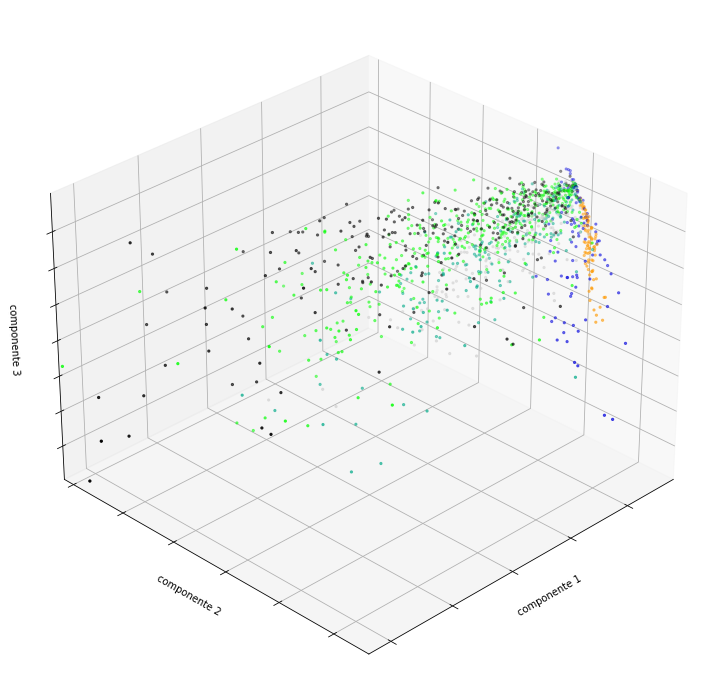

In [215]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()

ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=30, azim=45)
ax.scatter(x_pca3[:, 0], x_pca3[:, 1], x_pca3[:, 2], c=yy,
          cmap=plt.cm.nipy_spectral, marker="o", s=5)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel("componente 1")
ax.set_ylabel("componente 2")
ax.set_zlabel("componente 3")

ax.xaxis.zoom(2.75)
ax.yaxis.zoom(1)
# ax.zaxis.zoom(0)

plt.tight_layout()
plt.show()

In [84]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_pca3, yy):
    Xt, Xh = x_pca3[train_index], x_pca3[test_index]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 10) (428, 10) (855,) (428,)
(855, 10) (428, 10) (855,) (428,)
(856, 10) (427, 10) (856,) (427,)


In [85]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [86]:
shape_ = (Xt.shape[1], len(np.unique(yt)))
shape_

(10, 6)

In [87]:
try:
    del model_reglog
except:
    pass

In [89]:
with pm.Model() as model_reglog:    
    alfa = pm.Uniform("alfa", lower=lower, upper=higher, shape=shape_[1] )
    beta = pm.Laplace("beta", mu=0, b=b, shape=shape_)
    
    mu = pm.Deterministic("mu", alfa + pm.math.dot(Xt, beta))
    
    p = pm.Deterministic( "p", tt.nnet.softmax(mu) )

In [90]:
with model_reglog:
    observed = pm.Categorical("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 5000
#     trace = pm.sample(n_, step=step, start=start)
    trace = pm.sample(n_, step=step, start={"alfa":np.zeros(shape_[1]), "beta":np.zeros(shape_)})
    burned_trace = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alfa]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [91]:
# pm.traceplot(burned_trace) 
# plt.show()

In [92]:
gc.collect()

72382

In [94]:
pd.DataFrame(burned_trace["beta"].mean(0).T)

,0,1,2,3,4,5,6,7,8,9
0,1.019220,-1.618895,1.618801,0.031943,-0.370327,-1.465913,0.842753,-0.249453,0.096673,0.634314
1,-1.362510,2.071641,-0.568314,0.231977,0.136788,1.023451,-0.375035,0.280449,-0.117522,0.016381
2,0.724774,-0.723639,-0.352656,0.191422,-0.098207,-0.513457,-0.071887,0.162322,0.295452,-0.254445
3,0.973810,-1.537663,0.337672,-0.069037,-0.384198,-0.864474,0.314178,0.337352,-0.170352,-0.356945
4,-2.346072,3.540322,0.625015,-0.742122,0.905148,1.240456,-0.373786,-0.263883,1.509991,-0.699291
5,0.218386,-0.233490,-0.827435,0.267573,0.399543,-0.057326,-0.117963,0.296121,-0.493457,0.234106


In [95]:
pd.DataFrame(burned_trace["alfa"].mean(0).T, columns=["alfa"])

,alfa
0,3.135424
1,-2.517909
2,3.494290
3,4.209409
4,-7.252028
5,2.769203


In [96]:
y_prob = burned_trace['mu'].mean(0)
y_pred = [ np.exp(pp)/np.sum(np.exp(pp), axis=0) for pp in y_prob ]
y_pred = np.argmax(y_pred, axis=1)

In [97]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       190
           1       0.66      0.55      0.60        64
           2       0.60      0.25      0.35       134
           3       0.52      0.71      0.60       272
           4       0.81      0.92      0.86        60
           5       0.55      0.53      0.54       136

    accuracy                           0.61       856
   macro avg       0.64      0.61      0.61       856
weighted avg       0.61      0.61      0.59       856



In [107]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


In [98]:
h_pred = burned_trace['alfa'].mean(0) + np.dot(Xh, burned_trace['beta'].mean(0))

In [99]:
h_prob = np.exp(h_pred).T/np.sum(np.exp(h_pred), axis=1)

In [100]:
h_pred = np.argmax(h_prob, axis=0)

In [101]:
print( classification_report(yh, h_pred) )

              precision    recall  f1-score   support

           0       0.75      0.68      0.71        95
           1       0.56      0.44      0.49        32
           2       0.32      0.12      0.18        66
           3       0.50      0.74      0.60       136
           4       0.72      0.90      0.80        31
           5       0.33      0.24      0.28        67

    accuracy                           0.54       427
   macro avg       0.53      0.52      0.51       427
weighted avg       0.52      0.54      0.51       427



In [102]:
perc = .10

display( (pd.DataFrame(h_prob.T) > 1 - perc).sum(axis=1).value_counts() )
print()
display( (pd.DataFrame(h_prob.T) < perc).sum(axis=1).value_counts() )
print()
print(Xh.shape)

0    396
1     31
dtype: int64

4    152
3    131
2     82
5     39
1     16
0      7
dtype: int64


(427, 10)


In [103]:
del model_reglog

In [104]:
gc.collect()

8

## lda

In [112]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [113]:
scaler = MinMaxScaler()
scaler = StandardScaler()

yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [114]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

In [119]:
np.min([len(x_.columns), len(np.unique(yy))-1])

5

In [120]:
n_ = 5
lda = LDA(n_components = n_)
lda.fit(x_, yy)

LinearDiscriminantAnalysis(n_components=5)

In [121]:
x_lda = lda.transform(x_)

In [122]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


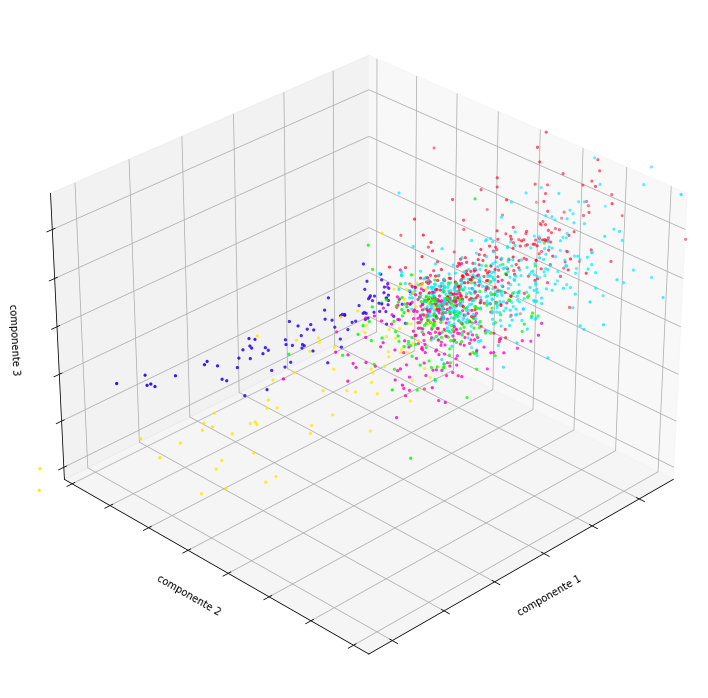

In [182]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()

ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=30, azim=45)
ax.scatter(x_lda[:, 0], x_lda[:, 1], x_lda[:, 2], c=yy,
          cmap=plt.cm.gist_rainbow, marker="o", s=5)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

# ax.set_xlim([x_lda[:, 0].min(), x_lda[:, 0].max()])
# ax.set_ylim([x_lda[:, 1].min(), x_lda[:, 1].max()])
# ax.set_zlim([x_lda[:, 2].min(), x_lda[:, 2].max()])

ax.set_xlabel("componente 1")
ax.set_ylabel("componente 2")
ax.set_zlabel("componente 3")

ax.xaxis.zoom(2.75)
# ax.yaxis.zoom(0)
# ax.zaxis.zoom(0)

plt.tight_layout()
plt.show()

In [124]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_lda, yy):
    Xt, Xh = x_lda[train_index], x_lda[test_index]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 5) (428, 5) (855,) (428,)
(855, 5) (428, 5) (855,) (428,)
(856, 5) (427, 5) (856,) (427,)


In [125]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [126]:
shape_ = (Xt.shape[1], len(np.unique(yt)))
shape_

(5, 6)

In [127]:
try:
    del model_reglog
except:
    pass

In [128]:
with pm.Model() as model_reglog:    
    alfa = pm.Uniform("alfa", lower=lower, upper=higher, shape=shape_[1] )
    beta = pm.Laplace("beta", mu=0, b=b, shape=shape_)
    
    mu = pm.Deterministic("mu", alfa + pm.math.dot(Xt, beta))
    
    p = pm.Deterministic( "p", tt.nnet.softmax(mu) )

In [129]:
with model_reglog:
    observed = pm.Categorical("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 5000
#     trace = pm.sample(n_, step=step, start=start)
    trace = pm.sample(n_, step=step, start={"alfa":np.zeros(shape_[1]), "beta":np.zeros(shape_)})
    burned_trace = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alfa]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [130]:
# pm.traceplot(burned_trace) 
# plt.show()

In [131]:
gc.collect()

142220

In [132]:
pd.DataFrame(burned_trace["beta"].mean(0).T)

,0,1,2,3,4
0,-2.875260,-0.658138,0.161261,0.193814,-0.123306
1,1.754512,-1.043321,-0.749019,0.434216,0.752793
2,-0.446908,0.937708,0.184545,-0.625541,-0.255227
3,-2.353802,0.904093,0.499775,0.168842,0.252818
4,1.993490,-1.494325,0.751303,0.670220,0.021974
5,0.615947,0.876915,-0.334789,0.667566,-0.096140


In [133]:
pd.DataFrame(burned_trace["alfa"].mean(0).T, columns=["alfa"])

,alfa
0,0.559849
1,-2.139681
2,0.667485
3,1.338905
4,-3.405386
5,0.149308


In [134]:
y_prob = burned_trace['mu'].mean(0)
y_pred = [ np.exp(pp)/np.sum(np.exp(pp), axis=0) for pp in y_prob ]
y_pred = np.argmax(y_pred, axis=1)

In [135]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       190
           1       0.66      0.52      0.58        64
           2       0.58      0.39      0.46       134
           3       0.58      0.74      0.65       272
           4       0.75      0.85      0.80        60
           5       0.60      0.60      0.60       136

    accuracy                           0.63       856
   macro avg       0.65      0.62      0.63       856
weighted avg       0.64      0.63      0.63       856



In [136]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


In [137]:
h_pred = burned_trace['alfa'].mean(0) + np.dot(Xh, burned_trace['beta'].mean(0))

In [138]:
h_prob = np.exp(h_pred).T/np.sum(np.exp(h_pred), axis=1)

In [139]:
h_pred = np.argmax(h_prob, axis=0)

In [140]:
print( classification_report(yh, h_pred) )

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        95
           1       0.61      0.62      0.62        32
           2       0.56      0.41      0.47        66
           3       0.61      0.67      0.64       136
           4       0.78      0.81      0.79        31
           5       0.59      0.61      0.60        67

    accuracy                           0.64       427
   macro avg       0.65      0.64      0.64       427
weighted avg       0.64      0.64      0.64       427



In [141]:
perc = .10

display( (pd.DataFrame(h_prob.T) > 1 - perc).sum(axis=1).value_counts() )
print()
display( (pd.DataFrame(h_prob.T) < perc).sum(axis=1).value_counts() )
print()
print(Xh.shape)

0    362
1     65
dtype: int64

4    142
3    124
5     87
2     60
1     12
0      2
dtype: int64


(427, 5)


In [142]:
del model_reglog

In [143]:
gc.collect()

68

## tsne

In [183]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [184]:
scaler = MinMaxScaler()
scaler = StandardScaler()

yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [185]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

In [186]:
np.min([len(x_.columns), len(np.unique(yy))-1])

5

In [188]:
n_ = 3
tsne = TSNE(n_components = n_)
tsne.fit(x_)

TSNE(n_components=3)

In [190]:
x_tsne = tsne.fit_transform(x_)

In [122]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


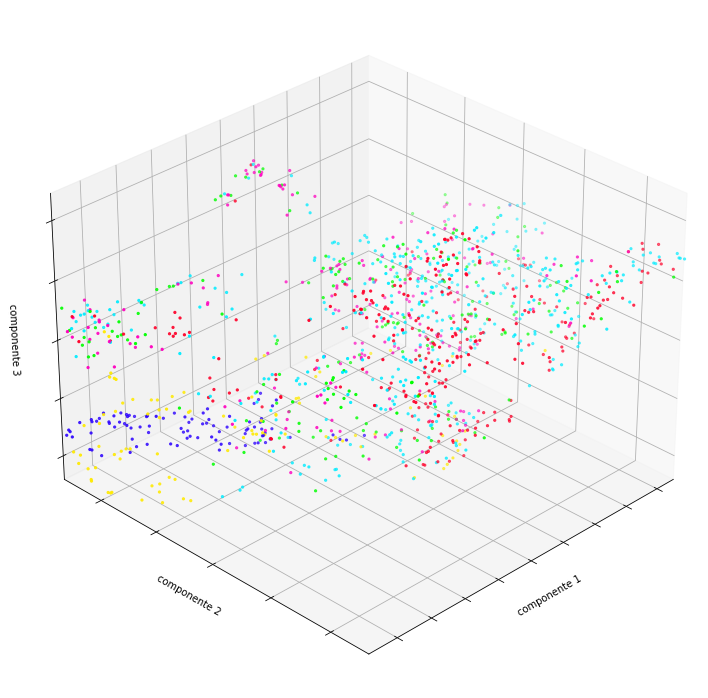

In [212]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()

ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=30, azim=45)
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=yy,
          cmap=plt.cm.gist_rainbow, marker="o", s=5)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

# ax.set_xlim([x_lda[:, 0].min(), x_lda[:, 0].max()])
# ax.set_ylim([x_lda[:, 1].min(), x_lda[:, 1].max()])
# ax.set_zlim([x_lda[:, 2].min(), x_lda[:, 2].max()])

ax.set_xlabel("componente 1")
ax.set_ylabel("componente 2")
ax.set_zlabel("componente 3")

ax.xaxis.zoom(2)
# ax.yaxis.zoom(0)
# ax.zaxis.zoom(0)

plt.tight_layout()
plt.show()

In [192]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_tsne, yy):
    Xt, Xh = x_tsne[train_index], x_tsne[test_index]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 3) (428, 3) (855,) (428,)
(855, 3) (428, 3) (855,) (428,)
(856, 3) (427, 3) (856,) (427,)


In [193]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [194]:
shape_ = (Xt.shape[1], len(np.unique(yt)))
shape_

(3, 6)

In [195]:
try:
    del model_reglog
except:
    pass

In [196]:
with pm.Model() as model_reglog:    
    alfa = pm.Uniform("alfa", lower=lower, upper=higher, shape=shape_[1] )
    beta = pm.Laplace("beta", mu=0, b=b, shape=shape_)
    
    mu = pm.Deterministic("mu", alfa + pm.math.dot(Xt, beta))
    
    p = pm.Deterministic( "p", tt.nnet.softmax(mu) )

In [197]:
with model_reglog:
    observed = pm.Categorical("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 5000
#     trace = pm.sample(n_, step=step, start=start)
    trace = pm.sample(n_, step=step, start={"alfa":np.zeros(shape_[1]), "beta":np.zeros(shape_)})
    burned_trace = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alfa]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [198]:
# pm.traceplot(burned_trace) 
# plt.show()

In [199]:
gc.collect()

91233

In [200]:
pd.DataFrame(burned_trace["beta"].mean(0).T)

,0,1,2
0,-0.125420,0.299549,0.225949
1,0.209312,-0.022520,-0.033345
2,-0.173035,0.080744,0.213224
3,-0.201821,0.143327,0.227608
4,0.188827,-0.593175,-0.176903
5,-0.186117,-0.077764,0.188982


In [201]:
pd.DataFrame(burned_trace["alfa"].mean(0).T, columns=["alfa"])

,alfa
0,1.253232
1,-2.052374
2,1.180511
3,1.849814
4,-5.140899
5,0.848287


In [202]:
y_prob = burned_trace['mu'].mean(0)
y_pred = [ np.exp(pp)/np.sum(np.exp(pp), axis=0) for pp in y_prob ]
y_pred = np.argmax(y_pred, axis=1)

In [203]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       190
           1       0.37      0.39      0.38        64
           2       0.00      0.00      0.00       134
           3       0.40      0.61      0.48       272
           4       0.64      0.77      0.70        60
           5       0.40      0.37      0.38       136

    accuracy                           0.44       856
   macro avg       0.39      0.44      0.41       856
weighted avg       0.38      0.44      0.40       856



In [204]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


In [205]:
h_pred = burned_trace['alfa'].mean(0) + np.dot(Xh, burned_trace['beta'].mean(0))

In [206]:
h_prob = np.exp(h_pred).T/np.sum(np.exp(h_pred), axis=1)

In [207]:
h_pred = np.argmax(h_prob, axis=0)

In [208]:
print( classification_report(yh, h_pred) )

              precision    recall  f1-score   support

           0       0.55      0.56      0.55        95
           1       0.36      0.31      0.33        32
           2       0.00      0.00      0.00        66
           3       0.43      0.59      0.50       136
           4       0.61      0.90      0.73        31
           5       0.38      0.40      0.39        67

    accuracy                           0.46       427
   macro avg       0.39      0.46      0.42       427
weighted avg       0.39      0.46      0.42       427



In [209]:
perc = .10

display( (pd.DataFrame(h_prob.T) > 1 - perc).sum(axis=1).value_counts() )
print()
display( (pd.DataFrame(h_prob.T) < perc).sum(axis=1).value_counts() )
print()
print(Xh.shape)

0    427
dtype: int64

3    167
2    118
4    101
1     33
0      7
5      1
dtype: int64


(427, 3)


In [210]:
del model_reglog

In [211]:
gc.collect()

70

## umap

In [11]:
scaler = MinMaxScaler()
scaler = StandardScaler()

yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [12]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

In [13]:
np.min([len(x_.columns), len(np.unique(yy))-1])

5

In [19]:
x_umap = umap.UMAP(n_neighbors=5, 
                       min_dist=0.3,
                       metric="correlation", 
                      n_components=3).fit_transform(x_)

In [20]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


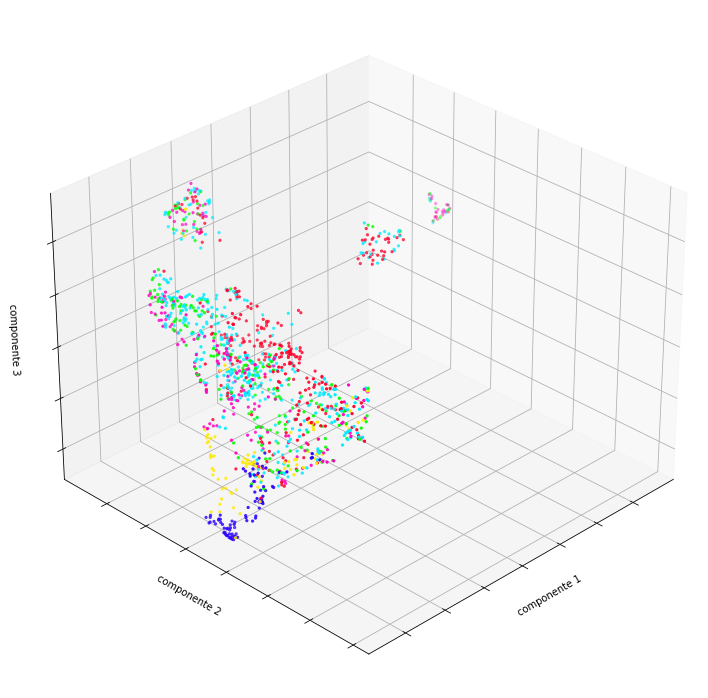

In [22]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()

ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=30, azim=45)
ax.scatter(x_umap[:, 0], x_umap[:, 1], x_umap[:, 2], c=yy,
          cmap=plt.cm.gist_rainbow, marker="o", s=5)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

# ax.set_xlim([x_lda[:, 0].min(), x_lda[:, 0].max()])
# ax.set_ylim([x_lda[:, 1].min(), x_lda[:, 1].max()])
# ax.set_zlim([x_lda[:, 2].min(), x_lda[:, 2].max()])

ax.set_xlabel("componente 1")
ax.set_ylabel("componente 2")
ax.set_zlabel("componente 3")

ax.xaxis.zoom(1)
# ax.yaxis.zoom(0)
# ax.zaxis.zoom(0)

plt.tight_layout()
plt.show()

In [23]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_umap, yy):
    Xt, Xh = x_umap[train_index], x_umap[test_index]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 3) (428, 3) (855,) (428,)
(855, 3) (428, 3) (855,) (428,)
(856, 3) (427, 3) (856,) (427,)


In [24]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [25]:
shape_ = (Xt.shape[1], len(np.unique(yt)))
shape_

(3, 6)

In [26]:
try:
    del model_reglog
except:
    pass

In [27]:
with pm.Model() as model_reglog:    
    alfa = pm.Uniform("alfa", lower=lower, upper=higher, shape=shape_[1] )
    beta = pm.Laplace("beta", mu=0, b=b, shape=shape_)
    
    mu = pm.Deterministic("mu", alfa + pm.math.dot(Xt, beta))
    
    p = pm.Deterministic( "p", tt.nnet.softmax(mu) )

In [28]:
with model_reglog:
    observed = pm.Categorical("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 5000
#     trace = pm.sample(n_, step=step, start=start)
    trace = pm.sample(n_, step=step, start={"alfa":np.zeros(shape_[1]), "beta":np.zeros(shape_)})
    burned_trace = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alfa]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [29]:
# pm.traceplot(burned_trace) 
# plt.show()

In [30]:
gc.collect()

40031

In [31]:
pd.DataFrame(burned_trace["beta"].mean(0).T)

,0,1,2
0,-0.426894,0.067675,0.467681
1,0.196176,0.012380,-0.217027
2,-0.305953,-0.137295,0.388380
3,-0.310664,-0.055839,0.477564
4,0.436989,0.648765,-1.249204
5,-0.314795,-0.144090,0.343783


In [32]:
pd.DataFrame(burned_trace["alfa"].mean(0).T, columns=["alfa"])

,alfa
0,1.680118
1,-0.770090
2,1.904264
3,1.597626
4,-3.080157
5,2.357589


In [33]:
y_prob = burned_trace['mu'].mean(0)
y_pred = [ np.exp(pp)/np.sum(np.exp(pp), axis=0) for pp in y_prob ]
y_pred = np.argmax(y_pred, axis=1)

In [34]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.29      0.19      0.23       190
           1       0.54      0.39      0.45        64
           2       0.00      0.00      0.00       134
           3       0.36      0.81      0.50       272
           4       0.63      0.78      0.70        60
           5       0.00      0.00      0.00       136

    accuracy                           0.38       856
   macro avg       0.30      0.36      0.31       856
weighted avg       0.26      0.38      0.29       856



In [35]:
cats_ = pd.Categorical(X["POS_FIRST"]).categories.tolist()

for name,label in zip(cats_, [c for c in range(len(cats_))]):
    print(name, label)

ATA 0
GOL 1
LAT 2
MEI 3
TEC 4
ZAG 5


In [36]:
h_pred = burned_trace['alfa'].mean(0) + np.dot(Xh, burned_trace['beta'].mean(0))

In [37]:
h_prob = np.exp(h_pred).T/np.sum(np.exp(h_pred), axis=1)

In [38]:
h_pred = np.argmax(h_prob, axis=0)

In [39]:
print( classification_report(yh, h_pred) )

              precision    recall  f1-score   support

           0       0.25      0.15      0.19        95
           1       0.47      0.25      0.33        32
           2       0.00      0.00      0.00        66
           3       0.36      0.84      0.51       136
           4       0.64      0.87      0.74        31
           5       0.00      0.00      0.00        67

    accuracy                           0.38       427
   macro avg       0.29      0.35      0.29       427
weighted avg       0.25      0.38      0.28       427



In [40]:
perc = .10

display( (pd.DataFrame(h_prob.T) > 1 - perc).sum(axis=1).value_counts() )
print()
display( (pd.DataFrame(h_prob.T) < perc).sum(axis=1).value_counts() )
print()
print(Xh.shape)

0    427
dtype: int64

2    325
4     35
1     29
0     17
3     15
5      6
dtype: int64


(427, 3)


In [41]:
del model_reglog

In [42]:
gc.collect()

0

- - -

In [43]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [44]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:25]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df:  8.3 MiB
                       gscouts: 532.6 KiB
                             X: 275.8 KiB
                          gpos: 206.9 KiB
                            x_: 200.6 KiB
                            xx: 200.6 KiB
                      gmercado: 191.8 KiB
                        y_prob: 40.2 KiB
                        h_prob: 20.1 KiB
                        x_umap: 15.2 KiB
                            Xt: 10.1 KiB
                           _41:  9.5 KiB
                           _38:  9.4 KiB
                           _39:  9.4 KiB
                           _40:  9.4 KiB
                             _:  9.2 KiB
                            __:  9.2 KiB
                           _43:  9.2 KiB
                           _44:  9.2 KiB
                           _37:  9.1 KiB
                           _34:  8.8 KiB
                           _35:  8.8 KiB
                           _36:  8.8 KiB
                           _29:  8.2 KiB
          

.